https://www.kaggle.com/c/titanic
https://www.kaggle.com/alexisbcook/titanic-tutorial   
https://app.dataquest.io/m/289/introduction-to-numpy/7/selecting-columns-and-custom-slicing-ndarrays
https://neurohive.io/ru/osnovy-data-science/razbor-resheniya-zadachi-titanik-na-kaggle-dlya-nachinajushhih/
https://habr.com/ru/post/274171/
https://habr.com/ru/post/202090/
https://habr.com/ru/post/470535/ 

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('ggplot')
%matplotlib inline

os.chdir(r'C:\Users\Mr Alex\Documents\GitHub\Kaggle\Titanic')
trd = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')

#Сливаем открытые фреймы в один
td = pd.concat([trd, tsd], ignore_index=True, sort = False)

In [4]:
td.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
td.info()

In [ ]:
td.shape

In [ ]:
td.dtypes

In [ ]:
#Статистика по колонкам с объектами
td.describe(include=['O'])

In [ ]:
#Статистика по всем
td.describe(include="all")

In [ ]:
#Только по цифровым колонкам ищем нужное нам значение
td.mean(numeric_only = True)

In [ ]:
#Тепловая карта пропущенных значений
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [ ]:
#Статистика по родственникам на борту
td[['Parch', 'SibSp']].value_counts()

In [ ]:
#Оцениваем возраст
td["Age"].unique()
td["Age"].mean()
td_age = titanic['Age'].value_counts()
age_24_30 = td_age.loc[[24.00, 30.00]]
td.loc[:10, ["Age", "Sex"]]

In [ ]:
#Зависимая и независимые переменные. Сортировка выживших по полу и возрасту. 
td[["Survived", "Age", "Sex"]].value_counts().loc[1]

In [ ]:
#Зависимая и независимые переменные. Средняя доля выживших и среднее по возрасту и цене билета
td[["Survived", "Age", "Fare"]].mean(axis=0)

In [ ]:
#Получение сокращенного фрейма по конкретным критериям
td[td["Sex"].isin(['male'])].head()

In [ ]:
#Сортировка
td.sort_values('Age', ascending=False).head()

In [ ]:
#Агрегирование. Подсчет количества записей
td.groupby('Fare').count()

In [ ]:
#Рисуем гистограмму
td['Age'].hist(bins=40)

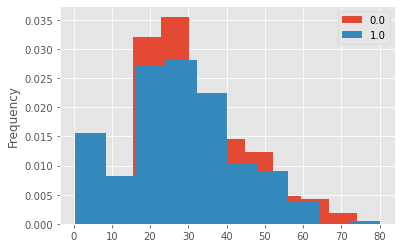

In [6]:
td.groupby('Survived')['Age'].plot.hist(density=True)
plt.legend()

In [5]:
for column in ['Survived', 'Pclass', 'Sex']:
    print(td[column].value_counts(normalize=True))

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64
3    0.541635
1    0.246753
2    0.211612
Name: Pclass, dtype: float64
male      0.644003
female    0.355997
Name: Sex, dtype: float64


In [6]:
# Нужно, чтобы подписи к картинкам отображались корректно по-русски
matplotlib.rc('font', family='Arial')

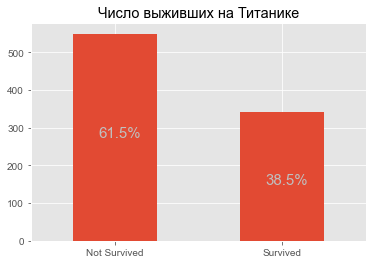

In [7]:
# Строим картинку
td['Survived'].value_counts().plot(kind='bar')
# Добавляем подпись
plt.title(u'Число выживших на Титанике')
plt.xticks([0, 1], ['Not Survived', 'Survived'], rotation=None)
plt.text(-0.1, 275, '61.5%', fontsize=15, color='silver')
plt.text(0.9, 150, '38.5%', fontsize=15, color='silver');

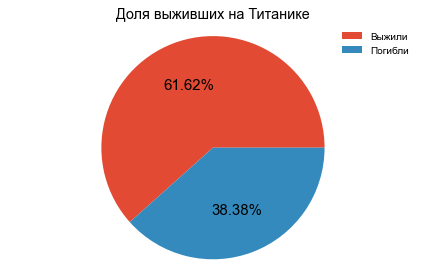

In [8]:
#Доля выживших на Титанике
fig, ax = plt.subplots(1)
td['Survived'].value_counts().plot(kind='pie', labels=['', ''],
                                   ax=ax, autopct='%.2f%%', fontsize=15)
ax.set_title(u'Доля выживших на Титанике')
ax.axis('equal')
ax.legend(labels=[u'Выжили', u'Погибли'], framealpha=0)
ax.set_ylabel('')
plt.tight_layout()

Text(0.5, 1.0, 'Распределение возраста')

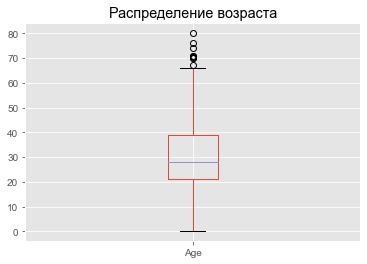

In [10]:
td['Age'].plot(kind='box')
plt.title(u'Распределение возраста')

Text(0.5, 0.98, '')

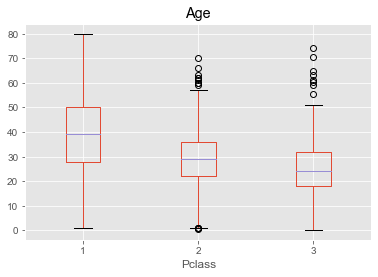

In [12]:
ax = td.boxplot(column='Age', by='Pclass')
# Хак для того, чтобы исправить наезжающие заголовки графика
ax.get_figure().suptitle('')